In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from networkx import grid_graph
import scipy as sc

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix, to_undirected



In [2]:
def generate_mixture_of_gaussians(X, p, K, limit_mu = 5, limit_sigma_high = 3, limit_sigma_low= 0.5):
    # Define the 2D Gaussian function
    dim_ambiant = X.shape[1]
    def gaussian(X, mu, sigma):
        dim_ambiant = X.shape[1]
        log_exp = 0
        for i in np.arange(dim_ambiant):
            log_exp += (X[:,i] - mu[i])**2 / (2 * sigma[i]**2)
            
        return np.exp(-log_exp)

    Z = np.zeros((X.shape[0], p))
    for i in np.arange(p):
        ### generate mixure weights:
        w = np.random.uniform(low=0., high=1, size=K)
        w = w/np.sum(w)
        z_temp = np.zeros((X.shape[0],))
        for k in np.arange(K):
            mu = np.array(np.random.uniform(low=-limit_mu, high=limit_mu, size=dim_ambiant))
            sigma = np.array(np.random.uniform(low=limit_sigma_low, high=limit_sigma_high, size=dim_ambiant))
            z_temp += w[i] * gaussian(X, mu, sigma)
        Z[:,i] = z_temp
    return(Z)


def generate_mixture_of_cosines(X, p, K, low_freq=0.4, high_freq=5):
    # Define the 2D Gaussian function
    dim_ambiant = X.shape[1]
    def sine_function(X, frequency):
        dim_ambiant = X.shape[1]
        res = 1.
        for i in np.arange(dim_ambiant):
            u = np.random.uniform(size=1)
            #print([i,u])
            if u >0.5:
                res *= np.cos(frequency[i] * X[:,i])
            else:
                res *= np.sin(frequency[i] * X[:,i])
        return(res)

    Z = np.zeros((X.shape[0], p))
    for i in np.arange(p):
        ### generate mixure weights:
        w = np.random.uniform(low=0., high=1, size=K)
        w = w/np.sum(w)
        z_temp = np.zeros((X.shape[0],))
        for k in np.arange(K):
            frequency = np.array(np.random.uniform(low=low_freq, high=high_freq, size=dim_ambiant))
            z_temp += w[i] * sine_function(X, frequency)
        Z[:,i] = z_temp
    return(Z)

In [3]:
criterion = torch.nn.MSELoss()


class GCN(torch.nn.Module):
    def __init__(self, input_dim, nb_convolutions=1, output_dim=1):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_dim, output_dim)
        #self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.conv2(x, edge_index)
        return x
        
    def train_data(self, data, train_mask):
          optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
          self.train()
          optimizer.zero_grad()  # Clear gradients.
          out = self.forward(data.x, data.edge_index)  # Perform a single forward pass.
          loss = criterion(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          return loss

    def test_data(self, data, f, scale):
          new_Y = np.random.normal(f, scale=scale)
          self.eval()
          pred = self.forward(data.x, data.edge_index)
          test_mse = criterion(pred, torch.from_numpy(new_Y).float())  # Check against ground-truth labels.
          return test_mse, pred


In [11]:
Y

array([[0.00090066, 0.02335302, 0.09682722],
       [0.00103969, 0.03198063, 0.12660361],
       [0.00118778, 0.04297665, 0.16128373],
       ...,
       [0.19094943, 0.02978361, 0.00651193],
       [0.17653717, 0.02127484, 0.00591417],
       [0.145866  , 0.01478805, 0.00533924]])

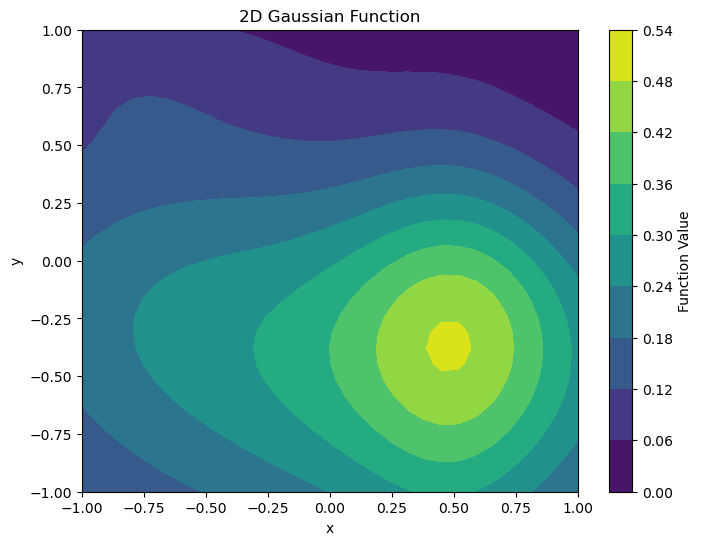

In [16]:
Y = generate_mixture_of_gaussians(X_pos,  3, 4, limit_mu = 0.9, limit_sigma_high = 1, limit_sigma_low= 0.1)
beta = np.random.uniform(size= X.shape[1])
f = X @ beta

values = f # Extract values based on node order
x = np.linspace(-1, 1, 30)
y = np.linspace(-1, 1, 30)
x, y = np.meshgrid(x, y)


# Plot the function
plt.figure(figsize=(8, 6))
plt.contourf(x, y, values.reshape(x.shape), cmap='viridis')
plt.colorbar(label='Function Value')
plt.title('2D Gaussian Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# norm = plt.Normalize(vmin=min(values), vmax=max(values))
# cmap = plt.cm.viridis  # You can change the colormap here
# colors = [cmap(norm(value)) for value in values]
# nx.draw_kamada_kawai(G, node_color=colors, with_labels=False)
# plt.show()


In [9]:
# Define the grid dimension
import pandas as pd
k = 30
# Create the grid graph
G = nx.grid_graph(dim=[k, k])
# Create the meshgrid for the coordinates
x = np.linspace(-1, 1, k)
y = np.linspace(-1, 1, k)
x, y = np.meshgrid(x, y)
# Reshape and combine the coordinates
X_pos = np.hstack([x.reshape([-1, 1]), y.reshape([-1, 1])])
# Create the position dictionary
pos = {(i % k, i // k): [X_pos[i, 0], X_pos[i, 1]] for i in np.arange(X_pos.shape[0])}
n = nx.number_of_nodes(G)
A = nx.adjacency_matrix(G)
A = A.todense() + np.eye(n)
D = np.diag(1./ np.sum(A, 1)**0.5)
A_tilde = D @ A @ D
#edge_index, edge_weights = from_scipy_sparse_matrix(A)
#edge_index, edge_weights = to_undirected(edge_index, edge_weights)

L = nx.laplacian_matrix(G)

nb_exp = 10
p = 10
K = 4
results = np.zeros((nb_exp  * 7 * 6, 26))
#results = np.zeros((nb_exp * 7 * 5 * 6 * 6, 26))
it = 0
for k in [1,2,3,4,5,6]:
    A_k = np.linalg.matrix_power(A_tilde, k)
    for scale in [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0]:
    #    for M in [0.3, 0.5, 1, 5, 10]:
    #        for alpha in [0.01, 0.1, 0.25, 0.5, 0.75, 1]:
                print([k, scale])
                for exp in np.arange(nb_exp):
                    ###
                    Z_1 =  generate_mixture_of_gaussians(X_pos,  3, 4, limit_mu = 0.9, limit_sigma_high = 1, limit_sigma_low= 0.1)
                    #Z_2 = generate_mixture_of_cosines(X_pos, 3, 3, low_freq=1, high_freq=5)
                    X = Z_1
                    
                    #### Create signal
                    beta = np.random.uniform(size= X.shape[1])
                    f = X @ beta 
                    Y = np.random.normal(f, scale=scale) 
                    #Y = np.random.normal(f, scale=scale)
                    Y_pred = A_k @ Y
                    ### Fit a GNN to predict what Y is:
                    #data = Data(x=torch.from_numpy(X).float(),
                    #            y = torch.from_numpy(Y).float(),
                    #            edge_index=edge_index,
                    #            edge_weight=edge_weights)
                    #model = GCN(input_dim= X.shape[1], output_dim=1)
                    #data.train_mask = np.random.binomial(n=1, p=0.75, size=n)
                    #data.test_mask = 1-data.train_mask
                    #train_mask  = np.ones((n,))
                    
                    #for epoch in range(1, 101):
                    #    loss = model.train_data(data, train_mask)
                        #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            
                    #pred = model(data.x, data.edge_index)
                    train_acc = np.mean(np.square(Y_pred - Y)) 
                    res_temp = [exp, k,  scale, p, K, float(train_acc)]
                    for u in range(20):
                        new_Y = np.random.normal(f, scale=scale)
                        test_mse = (np.square(Y_pred - new_Y)).mean()
                        res_temp += [float(test_mse)]
                    results[it, :] = res_temp
                    pd.DataFrame(results).to_csv("~/Downloads/res_mixtures.csv")
                    it += 1
                    #print(it)

                
    
        


[1, 0.01]
[1, 0.1]
[1, 0.25]
[1, 0.5]
[1, 0.75]
[1, 1.0]
[1, 2.0]
[2, 0.01]
[2, 0.1]
[2, 0.25]
[2, 0.5]
[2, 0.75]
[2, 1.0]
[2, 2.0]
[3, 0.01]
[3, 0.1]
[3, 0.25]
[3, 0.5]
[3, 0.75]
[3, 1.0]
[3, 2.0]
[4, 0.01]
[4, 0.1]
[4, 0.25]
[4, 0.5]
[4, 0.75]
[4, 1.0]
[4, 2.0]
[5, 0.01]
[5, 0.1]
[5, 0.25]
[5, 0.5]
[5, 0.75]
[5, 1.0]
[5, 2.0]
[6, 0.01]
[6, 0.1]
[6, 0.25]
[6, 0.5]
[6, 0.75]
[6, 1.0]
[6, 2.0]


In [8]:
it

70